In [1]:
import rasterio as rst
import rasterio.mask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl 
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box

%matplotlib inline

# Get caravans and raster data

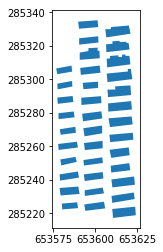

In [2]:
# read in caravans geometries
caravans = gpd.read_file('./Data/caravans.shp')
caravans.plot()

In [3]:
# read tile
tile = rst.open('./Data/Ortho_RGBN_P00081520_20160506_20160923_20cm_res.tif')

In [4]:
# get xmin and ymin of image tile
tile_xmin, tile_ymax, cellsize = (tile.bounds.left, tile.bounds.top, tile.res[0])

In [5]:
# get image array
image = tile.read()

In [6]:
# move axis and drop infrared channel
image = np.moveaxis(image,0,-1)[:,:,0:3]

(4000, 3000)

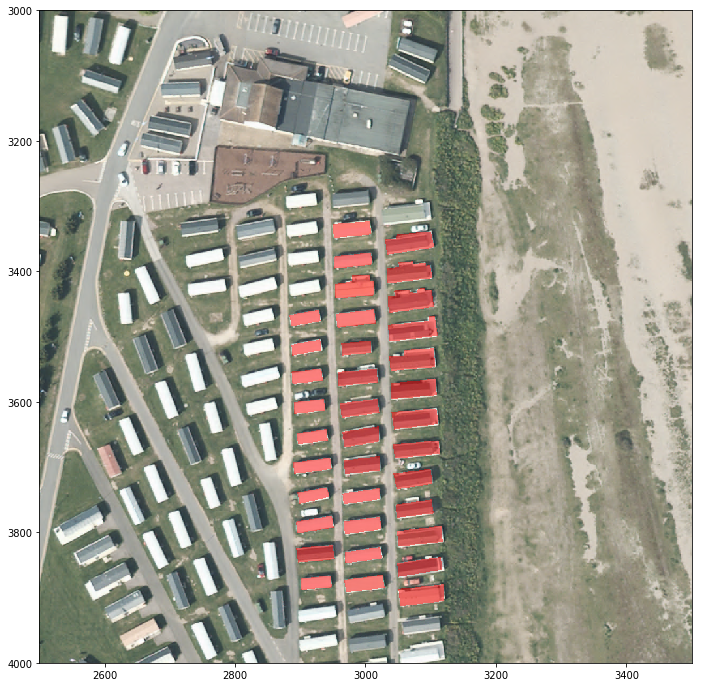

In [7]:
f, ax = plt.subplots(figsize = (12,12))
# plot image
ax.imshow(image)
# make and plot mask of caravans in red.
caravan_mask = mask.raster_geometry_mask(tile, caravans['geometry'], invert=True)[0]
ax.imshow(caravan_mask, alpha = 0.5, cmap = mpl.colors.ListedColormap(['None','r']))

# zoom to area that holds caravan masks
ax.set_xlim([2500,3500])
ax.set_ylim([4000,3000])

# Plot centroids of caravans in image coords

In [8]:
def getImageCoords(geom, xmin, ymax, cellsize):
    c_x, c_y = np.array(geom.centroid)
    img_x = (c_x - xmin) / cellsize
    img_y = (ymax - c_y) / cellsize
    return Point(img_x, img_y)

In [9]:
centroids = caravans['geometry'].apply(lambda x: getImageCoords(x, tile_xmin, tile_ymax, cellsize))

(4000, 3000)

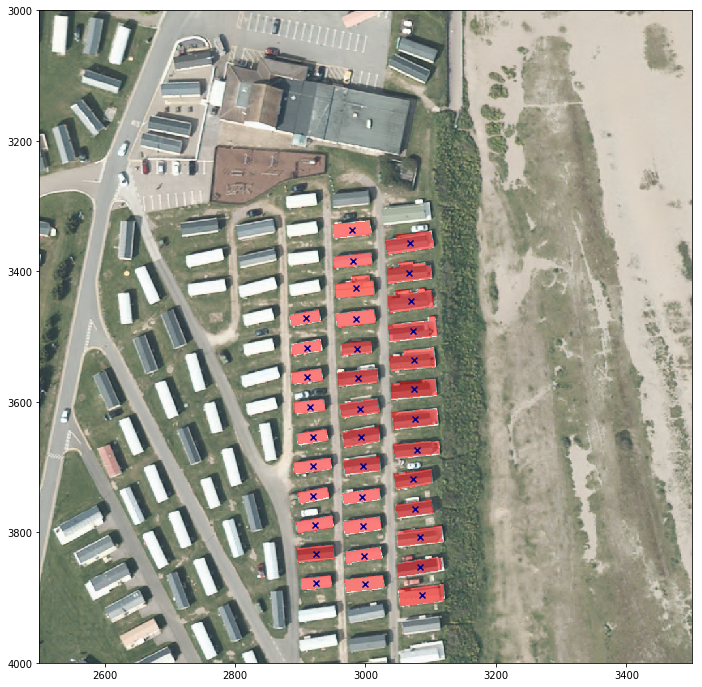

In [10]:
f, ax = plt.subplots(figsize = (12,12))
# plot image
ax.imshow(image)
# make and plot mask of caravans in red.
caravan_mask = mask.raster_geometry_mask(tile, caravans['geometry'], invert=True)[0]
ax.imshow(caravan_mask, alpha = 0.5, cmap = mpl.colors.ListedColormap(['None','r']))

# plot centroids
centroids.plot(color = 'darkblue', marker = 'x', ax=ax)

# zoom to area that holds caravan masks
ax.set_xlim([2500,3500])
ax.set_ylim([4000,3000])

# Create boxes

In [11]:
def getImageBox(geom, xmin, ymax, cellsize):
    c_x, c_y = np.array(geom.centroid)
    img_x = ((c_x - xmin) // cellsize) - 112
    img_y = ((ymax - c_y) // cellsize) - 112
    return box(img_x, img_y, img_x + 224, img_y + 224)

In [12]:
boxes = caravans['geometry'].apply(lambda x: getImageBox(x, tile_xmin, tile_ymax, cellsize))

(4000, 3000)

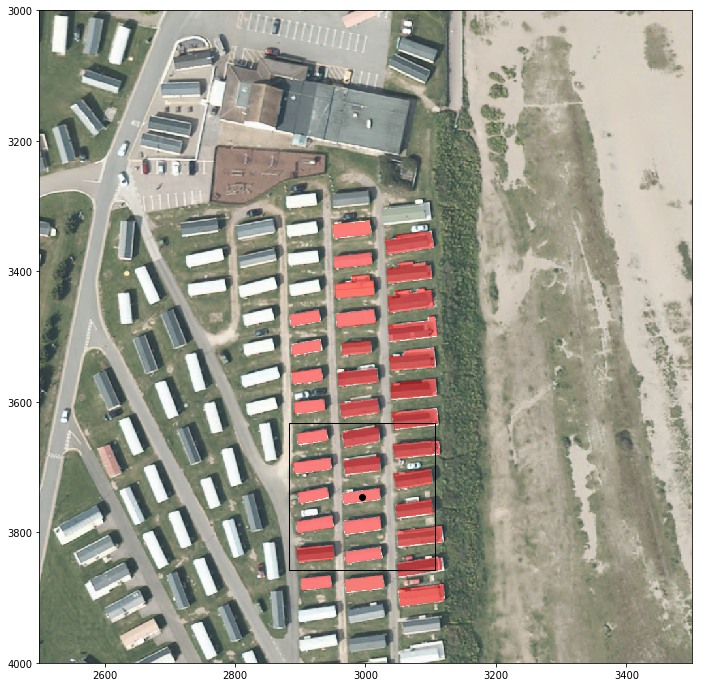

In [13]:
f, ax = plt.subplots(figsize = (12,12))
# plot image
ax.imshow(image)
# make and plot mask of caravans in red.
caravan_mask = mask.raster_geometry_mask(tile, caravans['geometry'], invert=True)[0]
ax.imshow(caravan_mask, alpha = 0.5, cmap = mpl.colors.ListedColormap(['None','r']))

# plot example centroid and box
centroids[0:1].plot(color = 'k', ax=ax)
boxes[0:1].plot(facecolor = 'none', edgecolor = 'k', ax=ax)

# zoom to area that holds caravan masks
ax.set_xlim([2500,3500])
ax.set_ylim([4000,3000])

# Get image subsets

In [14]:
def subSetImage(image, box):
    xmin, ymin, xmax, ymax = map(int, box.bounds)
    return image[ymin:ymax,xmin:xmax,:]

In [15]:
subsets = []
for box in boxes.sample(9):
    subsets.append(subSetImage(image, box))

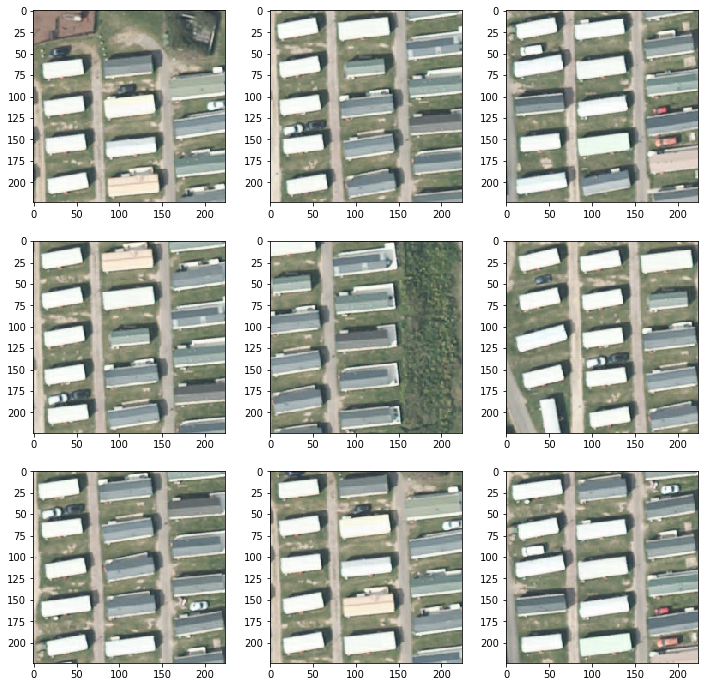

In [16]:
f, axes = plt.subplots(3,3,figsize = (12,12))
# plot images
i = 0
for row in axes:
    for ax in row:
        ax.imshow(subsets[i])
        i+=1